In [24]:
# S2 signal script
import sys
sys.path.append('/home/investigator/mariandbt/python/notebooks/modules')
sys.path.append('/scratch/marian/python/notebooks/modules')

from datetime import datetime
import matplotlib.dates as mdates  # Import for date formatting

from import_modules import *
import set_up as setup

from scipy.optimize import curve_fit
from scipy.signal import find_peaks

import glob
import re

##  Functions

In [25]:
# Sort the files based on the number that appears right before the '.h5' extension
def extract_number_h5(file):
    # Extract the number before '.h5' using regex
    match = re.search(r'_(\d+)\.h5$', file)  # Matches '_number.h5'
    return int(match.group(1)) if match else float('inf')  # Extract the number or return 'inf'


In [26]:

CHAmp={
"CH1":535,
"CH2":537,
"CH3":684,
"CH4":675}

temp = 'room'

if temp == 'room':
    # Samuele's (20241025) RoomTemp
    ConvPar={
    "CH1":(2.75e-8,-6.32e-9), # V*s
    "CH2":(3.18e-8,-5.60e-9), # V*s
    "CH3":(3.58e-8,-3.49e-9), # V*s
    "CH4":(3.87e-8,-4.68e-9)  # V*s
    }

if temp == '14deg':
    # Marian's (20241022) 14deg
    ConvPar={
    "CH1":(3.26e-8,-7.32e-9), # V*s
    "CH2":(3.79e-8,-1.06e-8), # V*s
    "CH3":(4.44e-8,-1.03e-8), # V*s
    "CH4":(4.13e-8,-1.07e-8)  # V*s
    }

def ChargeToPes(integral, p0, p1):
    
#     integral is in V*us
    
    photoelectrons = (integral - p1) / p0
    return photoelectrons

# charge_in_pes = ChargeToPes(charge_in_Vus[f'CH{ii}']*CHAmp[f'CH{ii}'], *ConvPar[f'CH{ii}'])

##  Data reading

In [27]:
# path = '/home/investigator/mariandbt/python/data'
path = '/scratch/marian/python/data'
path = path + '/cigar'

##  Signal peak

In [28]:
runs = {
#         1.5: '20241011_with_am_1.5bar_N_14.0deg_no_amp', # only CH1
#         2.5: '20241011_with_am_2.5bar_N_14.0deg_no_amp', 
#         3.5: '20241011_with_am_3.5bar_N_14.0deg_no_amp', 
#         4.5: '20241016_with_am_4.5bar_N_14.0deg_no_amp', 
#         5.5: '20241018_with_am_5.5bar_Ar_14.0deg_no_amp', # only CH1
#         6.5: '20241021_with_am_6.5bar_Ar_14.0deg_no_amp', 
#         6.5: '20241022_with_am_6.5bar_Ar_14.0deg_no_amp', 
#         6.5: '20241022_with_am_6.5bar_Ar_roomtemp_no_amp', 
#         7.5: '20241023_with_am_7.5bar_Ar_roomtemp_no_amp', 
#         7.5: '20241024_with_am_7.5bar_Ar_roomtemp_no_amp', 
#         8.2: '20241028_with_am_8.2bar_Ar_roomtemp_no_amp', 
#         8.5: '20241025_with_am_8.5bar_Ar_roomtemp_no_amp',
        8.5: '20241029_with_am_inside_8.5bar_Ar_roomtemp_no_amp',
        7.5: '20241030_with_am_inside_7.5bar_Ar_roomtemp_no_amp',
        6.5: '20241031_with_am_inside_6.5bar_Ar_roomtemp_no_amp',
        5.5: '20241104_with_am_inside_5.5bar_Ar_roomtemp_no_amp',
#         5.5: '20241104_with_am_inside_5.5bar_Ar_roomtemp_no_amp_run2', # Hot getter mostly off 
        4.5: '20241105_with_am_inside_4.5bar_Ar_roomtemp_no_amp',
        3.5: '20241106_with_am_inside_3.5bar_Ar_roomtemp_no_amp',
        2.5: '20241107_with_am_inside_2.5bar_Ar_roomtemp_no_amp',
        1.5: '20241108_with_am_inside_1.5bar_Ar_roomtemp_no_amp',
        1.0: '20241111_with_am_inside_1.0bar_Ar_roomtemp_no_amp'
       }

In [29]:
bars     = 2.5
run      = runs[bars]

run_path = os.path.join(path, run) 

# Use glob to find all .h5 files in the directory
h5_files = glob.glob(f"{run_path}/*.h5")
h5_files = sorted(h5_files, key=extract_number_h5)


In [30]:
ch1s = []
ch2s = []
ch3s = []
ch4s = []

time_ticks = 6250
top_files  = -1

for file in h5_files[-13:top_files]:
    
    print(f'Processing... {file}' + ' '*20, end = '\r')
    
    df = pd.read_hdf(file)
    
    time = df["TIME"].to_numpy()[:time_ticks] # [s]
    ch1 = df["CH1"].to_numpy().reshape(-1, time_ticks)  # [V]
    ch2 = df["CH2"].to_numpy().reshape(-1, time_ticks)  # [V]
    ch3 = df["CH3"].to_numpy().reshape(-1, time_ticks)  # [V]
    ch4 = df["CH4"].to_numpy().reshape(-1, time_ticks)  # [V]
    
    # Peak correction
    for ch in [ch1, ch2, ch3, ch4]:
        inf_mask = np.isinf(ch)
        neg_inf_mask = np.isneginf(ch)
        
        ch[inf_mask] = ch[np.isfinite(ch)].max()
        ch[neg_inf_mask] = ch[np.isfinite(ch)].min()
        
    
    integration_window = (time > -3e-6) & (time < 9e-6)
    
    ch1_area = np.trapz(ch1[:, integration_window], time[integration_window], axis=1)
    ch2_area = np.trapz(ch2[:, integration_window], time[integration_window], axis=1)
    ch3_area = np.trapz(ch3[:, integration_window], time[integration_window], axis=1)
    ch4_area = np.trapz(ch4[:, integration_window], time[integration_window], axis=1)
    
    ch1s.append(ch1_area)
    ch2s.append(ch2_area)
    ch3s.append(ch3_area)
    ch4s.append(ch4_area)
    
ch1s = np.array(ch1s)
ch2s = np.array(ch2s)
ch3s = np.array(ch3s)
ch4s = np.array(ch4s)
    
print(f'DONE! Last file processed: {file}' + ' '*20, end = '\r')


In [31]:
charge_df = pd.DataFrame({'charge_CH1':ch1s.flatten(), 
                          'charge_CH2':ch2s.flatten(),
                          'charge_CH3':ch3s.flatten(),
                          'charge_CH4':ch4s.flatten()
                         })


In [32]:
charge_df.max()

charge_CH1    3.800234e-08
charge_CH2    5.079517e-08
charge_CH3    3.886641e-08
charge_CH4    3.487065e-08
dtype: float64

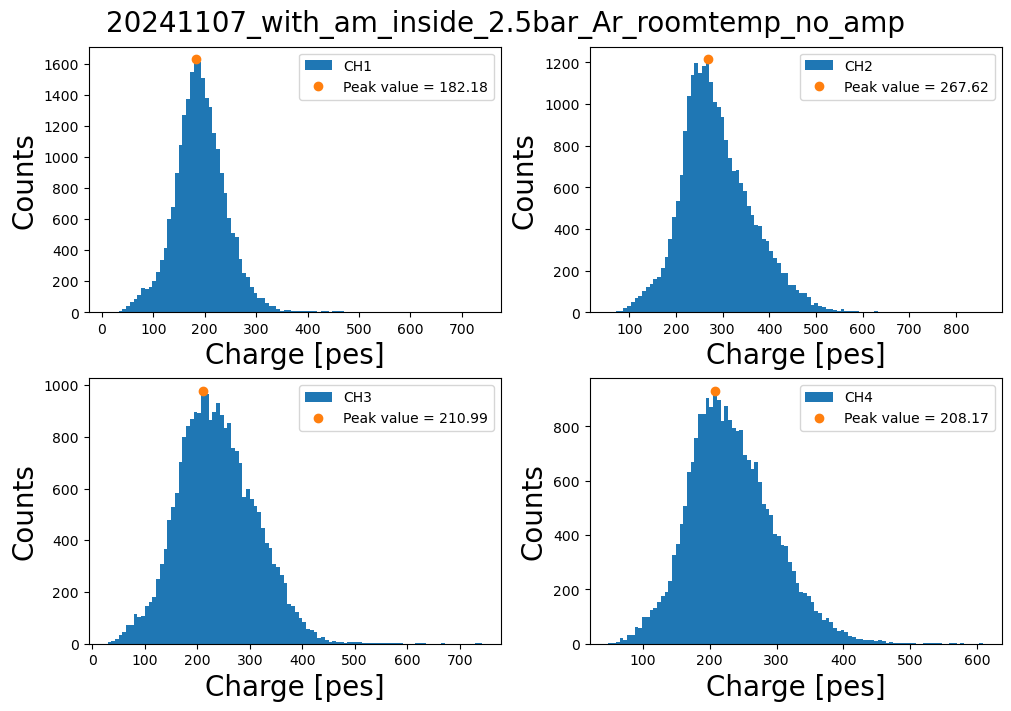

In [33]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(10,7), constrained_layout=True)

font_size = 20
nbins = 100

pes = True

for i, ii in enumerate([1, 2, 3, 4]):
# for i, ii in enumerate([4]):
    axx = ax[(i // 2) % 2, i%2]

    if pes:
        charge_in_pes = ChargeToPes(charge_df[f'charge_CH{ii}']*CHAmp[f'CH{ii}'], *ConvPar[f'CH{ii}'])
        events, bins, image = axx.hist(charge_in_pes, bins = nbins, label = f'CH{ii}', alpha = 1)
#         axx.set_xlim(0, 500)        
    else:
        events, bins, image = axx.hist(charge_df[f'charge_CH{ii}']*1e6, bins = nbins, label = f'CH{ii}', alpha = 1)
#         axx.set_xlim(0, 0.02)        

    # axx.set_title(f'Multiphoton spectrum', fontsize = font_size);
#     axx.set_title(f'{run}', fontsize = font_size);

    if pes:
        axx.set_xlabel(r'Charge [pes]', fontsize = font_size);
    else:
        axx.set_xlabel(r'Charge [V $\cdot$ $\mu$ s]', fontsize = font_size);
        
    axx.set_ylabel(r'Counts', fontsize = font_size);
    
    peaks, _ = find_peaks(events, height=500, distance=15)  # Adjust 'height' as needed to filter smaller peaks
    peak_values = [(bins[i] + bins[i + 1]) / 2 for i in peaks]

    axx.plot(peak_values, events[peaks], 'o', label = f'Peak value = {max(peak_values):.2f}')
    
    # axx.set_yscale('log')
    axx.legend(loc = 'best')
    
# Set a general title for the entire figure
fig.suptitle(f'{run}', fontsize = font_size);



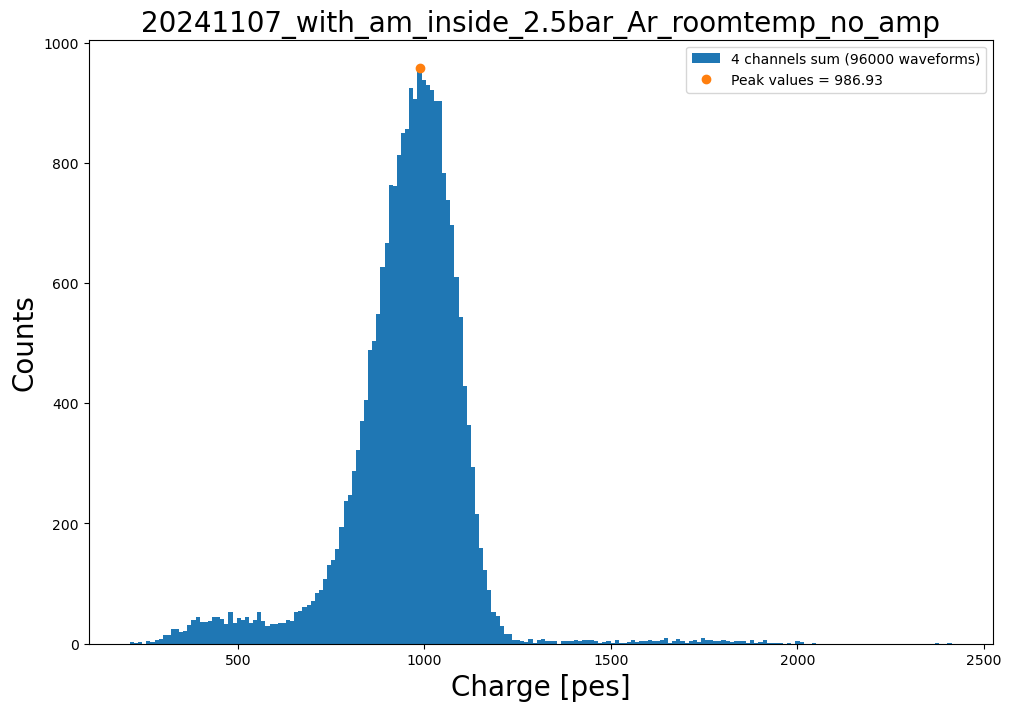

In [34]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,7), constrained_layout=True)

font_size = 20

charge_in_pes = pd.DataFrame([])

for i, ii in enumerate([1, 2, 3, 4]):
# for i, ii in enumerate([4]):

    charge_in_pes[f'charge_CH{ii}'] = ChargeToPes(charge_df[f'charge_CH{ii}']*CHAmp[f'CH{ii}'], *ConvPar[f'CH{ii}'])

total_charge_in_pes = charge_in_pes.sum(axis = 1)
total_charge_in_Vs = charge_df.sum(axis = 1)*1e6
    
if pes:
    events, bins, image = ax.hist(total_charge_in_pes, bins = nbins*2, 
                                  label = f'4 channels sum ({len(h5_files[:top_files])*2000} waveforms)', 
                                  alpha = 1 - .2*0)
    ax.set_xlabel(r'Charge [pes]', fontsize = font_size);
#     ax.set_xlim(0, 500)
else:
    
    events, bins, image = ax.hist(total_charge_in_Vs, bins = nbins*2, 
                                  label = f'4 channels sum ({len(h5_files[:top_files])*2000} waveforms)', 
                                  alpha = 1 - .2*0)
    ax.set_xlabel(r'Charge [V $\cdot$ $\mu$ s]', fontsize = font_size);
#     ax.set_xlim(0, 0.04)

# Find all peaks in the histogram
peaks, _ = find_peaks(events, height=200, distance=30)  # Adjust 'height' as needed to filter smaller peaks
peak_values = [(bins[i] + bins[i + 1]) / 2 for i in peaks]
peak_values = np.array(peak_values)

ax.plot(peak_values, events[peaks], 'o', 
        label =  f"Peak values = {', '.join(f'{peak:.2f}' for peak in peak_values)}")
    
# ax.set_title(f'Multiphoton spectrum', fontsize = font_size);
ax.set_title(f'{run}', fontsize = font_size);
ax.set_ylabel(r'Counts', fontsize = font_size);

# ax.set_yscale('log')
ax.legend(loc = 'best')


###  Peak vs Pressure

In [15]:
time_ticks = 6250
top_files  = -1

total_charge_dict = {}

for pressure, run in sorted(runs.items()):
    
    total_charge_dict[pressure] = []
    
    run_path = os.path.join(path, run) 

    # Use glob to find all .h5 files in the directory
    h5_files = glob.glob(f"{run_path}/*.h5")
    h5_files = sorted(h5_files, key=extract_number_h5)
    

    for file in h5_files[-13:top_files]:

        print(f'Processing... {file}' + ' '*20, end = '\r')

        df = pd.read_hdf(file)

        time = df["TIME"].to_numpy()[:time_ticks] # [s]
        ch1 = df["CH1"].to_numpy().reshape(-1, time_ticks)  # [V]
        ch2 = df["CH2"].to_numpy().reshape(-1, time_ticks)  # [V]
        ch3 = df["CH3"].to_numpy().reshape(-1, time_ticks)  # [V]
        ch4 = df["CH4"].to_numpy().reshape(-1, time_ticks)  # [V]

        # Peak correction
        for ch in [ch1, ch2, ch3, ch4]:
            inf_mask = np.isinf(ch)
            neg_inf_mask = np.isneginf(ch)

            ch[inf_mask] = ch[np.isfinite(ch)].max()
            ch[neg_inf_mask] = ch[np.isfinite(ch)].min()


        integration_window = (time > -3e-6) & (time < 9e-6)

        ch1_area = np.trapz(ch1[:, integration_window], time[integration_window], axis=1)
        ch2_area = np.trapz(ch2[:, integration_window], time[integration_window], axis=1)
        ch3_area = np.trapz(ch3[:, integration_window], time[integration_window], axis=1)
        ch4_area = np.trapz(ch4[:, integration_window], time[integration_window], axis=1)
        
        ch1_pes = ChargeToPes(ch1_area*CHAmp[f'CH{1}'], *ConvPar[f'CH{1}'])
        ch2_pes = ChargeToPes(ch2_area*CHAmp[f'CH{2}'], *ConvPar[f'CH{2}'])
        ch3_pes = ChargeToPes(ch3_area*CHAmp[f'CH{3}'], *ConvPar[f'CH{3}'])
        ch4_pes = ChargeToPes(ch4_area*CHAmp[f'CH{4}'], *ConvPar[f'CH{4}'])

        total_charge = ch1_pes + ch2_pes + ch3_pes + ch4_pes
        
        total_charge_dict[pressure].append(total_charge)


print(f'DONE! Last file processed: {file}' + ' '*20, end = '\r')


In [16]:
peaks_dict = {}

for pressure, pes in total_charge_dict.items():
    data = np.array(pes).flatten()
    # Compute the histogram
    hist, bin_edges = np.histogram(data, bins=nbins*2)
    
    # Find all peaks in the histogram
    peaks, _ = find_peaks(hist, height=300, distance=10)  # Adjust 'height' as needed to filter smaller peaks
    peak_values = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in peaks]
    peak_values = np.array(peak_values)
    
    peaks_dict[pressure] = max(peak_values)
#putaputaputa

In [17]:
peaks_dict

{1.0: 1197.2002755213737,
 1.5: 1153.3085017762342,
 2.5: 986.9331174844604,
 3.5: 970.8772676537604,
 4.5: 993.0007843504445,
 5.5: 1021.0435181122398,
 6.5: 1015.2070549158574,
 7.5: 1076.4803834828667,
 8.5: 1124.1682976439295}

In [18]:
reference_plot = {2.004: 1.075e5,
                  2.512: 1.088e5,
                  2.985: 1.122e5,
                  3.493: 1.180e5,
                  4.000: 1.233e5,
                  4.507: 1.285e5,
                  4.997: 1.325e5,
                  6.011: 1.526e5,
                  6.974: 1.727e5,
                  8.004: 1.903e5,
                  8.967: 2.072e5,
                  9.965: 2.183e5}

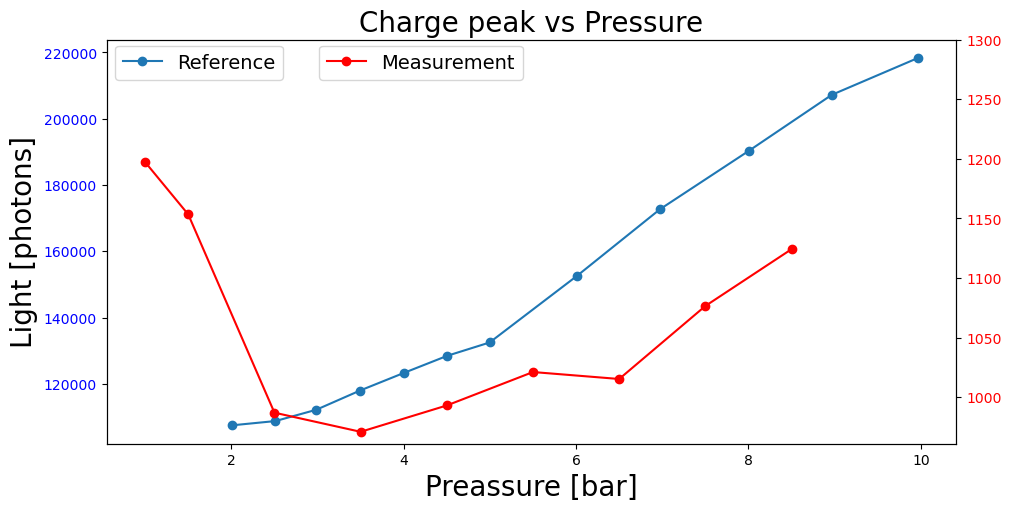

In [23]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5), constrained_layout=True)

font_size = 20

ax.plot(reference_plot.keys(), reference_plot.values(), '-o', label = r'Reference')

# Create a second y-axis
ax2 = ax.twinx()
ax2.plot(peaks_dict.keys(), peaks_dict.values(), '-or', label = r'Measurement')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc = (0.25, 0.9), fontsize = 0.7*font_size)
ax2.set_ylim(min(peaks_dict.values()) -10, 1300)

title = f'Charge peak vs Pressure'

ax.set_title(f'{title}', fontsize = font_size);
ax.set_ylabel(r'Light [photons]', fontsize = font_size);
ax.set_xlabel('Preassure [bar]', fontsize = font_size);
ax.tick_params(axis='y', labelcolor='b')

ax.legend(loc = (0.01, 0.9), fontsize = 0.7*font_size)
# ax.set_xlim(0, 2)

In [24]:
peaks_dict

{1.0: 1197.2002755213737,
 1.5: 1153.3085017762342,
 2.5: 986.9331174844604,
 3.5: 970.8772676537604,
 4.5: 993.0007843504445,
 5.5: 1021.0435181122398,
 6.5: 1015.2070549158574,
 7.5: 1076.4803834828667,
 8.5: 1124.1682976439295}